In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import uniform, seed
from scipy.interpolate import griddata
from matplotlib.font_manager import FontProperties

ModuleNotFoundError: No module named 'sklearn'

In [2]:
sns_colors = sns.color_palette('colorblind')

In [3]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))

In [5]:
xtrain = pd.read_csv('dataset/hotel_bookings.csv')
xtrain.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [6]:
xvalid = xtrain.loc[xtrain['reservation_status_date'] >= '2017-08-01']
xtrain = xtrain.loc[xtrain['reservation_status_date'] < '2017-08-01']

xvalid.info()
print("-"*40)
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3810 entries, 13153 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           3810 non-null   object 
 1   is_canceled                     3810 non-null   int64  
 2   lead_time                       3810 non-null   int64  
 3   arrival_date_year               3810 non-null   int64  
 4   arrival_date_month              3810 non-null   object 
 5   arrival_date_week_number        3810 non-null   int64  
 6   arrival_date_day_of_month       3810 non-null   int64  
 7   stays_in_weekend_nights         3810 non-null   int64  
 8   stays_in_week_nights            3810 non-null   int64  
 9   adults                          3810 non-null   int64  
 10  children                        3810 non-null   float64
 11  babies                          3810 non-null   int64  
 12  meal                        

In [7]:
ytrain, yvalid = xtrain['is_canceled'], xvalid['is_canceled']
xtrain.drop('is_canceled', axis=1, inplace=True)
xvalid.drop('is_canceled', axis=1, inplace=True)

In [8]:
xtrain.drop(['arrival_date_year', 'assigned_room_type', 'booking_changes', 'reservation_status', 'country', 'days_in_waiting_list'], axis=1, inplace=True)

In [9]:
num_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies","is_repeated_guest", "previous_cancellations", "previous_bookings_not_canceled", "agent", "company", "required_car_parking_spaces", "total_of_special_requests", "adr"]
cat_features = ["hotel", "arrival_date_month", "meal", "market_segment", "distribution_channel","reserved_room_type","deposit_type","customer_type"]

In [10]:
feature_columns = []
for feature_name in cat_features:
    vocabulary = xtrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in num_features:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [11]:
NUM_EXAMPLES = len(ytrain)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))

        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # for training, cycle thru dataset as many times as need (n_epochs=None)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

In [12]:
train_input_fn = make_input_fn(xtrain, ytrain)
eval_input_fn = make_input_fn(xvalid, yvalid, shuffle=False, n_epochs=1)

In [13]:
params = {
    'n_trees': 125,
    'max_depth': 5,
    'n_batches_per_layer': 1,
    'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmpg0936_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs in

In [14]:
est.train(train_input_fn, max_steps=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpmpg0936_/model.ckpt.
Type is unsuppo

In [15]:
# evaluation
result = est.evaluate(eval_input_fn)
pd.Series(result).to_frame()

INFO:tensorflow:Calling model_fn.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-07-09T16:02:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmpg0936_/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 2.18770s
INFO:tensorflow:Finished evaluation at 2022-07-09-16:02:37
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.73175853, accuracy_baseline = 0.9160105, auc = 0.63211495, auc_precision_recall = 0.18967871, average_loss = 0.53381085, global_step = 100, label/mean = 0.0839895, loss = 0.53381085, precision = 0.12095033, prediction/mean = 0.35387632, recall = 0.35
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warnin

,0
accuracy,0.731759
accuracy_baseline,0.916010
auc,0.632115
auc_precision_recall,0.189679
average_loss,0.533811
label/mean,0.083990
loss,0.533811
precision,0.120950
prediction/mean,0.353876
recall,0.350000


In [16]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmpg0936_/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [21]:
!pip install sklearn

     |████████████████████████████████| 22.2 MB 6.9 MB/s eta 0:00:01    |█████████                       | 6.3 MB 3.0 MB/s eta 0:00:06     |██████████████████████████████  | 20.8 MB 6.9 MB/s eta 0:00:01     |███████████████████████████████▌| 21.9 MB 6.9 MB/s eta 0:00:01     |████████████████████████████████| 22.2 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 5.1 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=d1aec134224d7d31c563ad4faf814356461f8a4880291facf4955cd94d451361
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


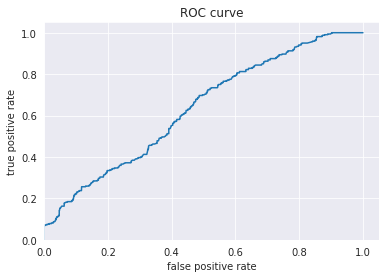

In [22]:
import sklearn
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(yvalid, probs)
plt.plot(fpr, tpr)

plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [23]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# create DFC pandas dataframe
labels = yvalid.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmpg0936_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

,count,mean,std,min,25%,50%,75%,max
arrival_date_day_of_month,3810.0,0.012899,0.024758,-0.009692,0.002193,0.003364,0.003898,0.094936
lead_time,3810.0,0.001731,0.065319,-0.219577,-0.026463,0.010521,0.041794,0.173277
arrival_date_week_number,3810.0,0.017920,0.021589,-0.032336,0.004783,0.012268,0.022143,0.130656
arrival_date_month,3810.0,0.019899,0.017779,-0.031339,0.006899,0.015169,0.030995,0.079928
adr,3810.0,0.015373,0.018547,-0.033255,0.000972,0.009192,0.026763,0.139819
previous_cancellations,3810.0,-0.022484,0.020113,-0.071294,-0.032794,-0.027811,-0.006534,0.267488
deposit_type,3810.0,-0.022288,0.013814,-0.088723,-0.023530,-0.022477,-0.020884,0.152275
agent,3810.0,0.003220,0.018369,-0.092485,-0.004625,0.000419,0.009331,0.092367
market_segment,3810.0,-0.007976,0.042616,-0.193202,-0.046233,0.001139,0.021092,0.084854
hotel,3810.0,0.000672,0.004336,-0.014450,0.000000,0.000000,0.000000,0.036013


In [24]:
def _get_color(value):
    """
    To make positive DFCs plot green, negative DFCs plot red.
    :param value:
    :return:
    """
    green, red = sns.color_palette()[2:4]
    return green if value >= 0 else red

In [25]:
from matplotlib.font_manager import FontProperties

def _add_feature_value(feature_values, ax):
    """
    display feature's values on left of plot
    :param feature_values:
    :param ax:
    :return:
    """
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
        font = FontProperties()
        font.set_weight('bold')
        t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue', fontproperties=font, size=12)